## FDW Crop Production Data Analysis - Burkina Faso

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
df = df[
    (df['season_name'] == 'Main') &
    (df['product'].isin(['Maize']))
]
area = df[df['indicator'] == 'area']
area['year'] = area['growing_year']
area = area.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
prod = df[df['indicator'] == 'production']
prod['year'] = prod['growing_year']
prod = prod.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
data = prod/area
# ---------------------------------------------------- #
data

year
1984    0.381748
1985    0.961218
1986    0.970259
1987    0.866501
1988    1.134445
1989    1.162269
1990    1.131926
1991    1.486271
1992    1.337613
1993    1.305954
1994    1.533996
1995    1.144090
1996    1.552075
1997    1.457950
1998    1.374415
1999    1.523281
2000    1.308085
2001    1.691172
2002    1.676518
2003    1.528412
2004    1.266616
2005    1.786347
2006    1.828737
2007    1.131262
2008    1.666151
2009    1.528548
2010    1.439761
2011    1.535594
2012    1.761151
2013    1.735294
2014    1.870941
2015    1.791954
2016    1.757679
2018    1.668130
2019    1.685768
Name: FDW, dtype: float64

Correlation:
           FDW      PRCP
FDW   1.000000  0.493589
PRCP  0.493589  1.000000


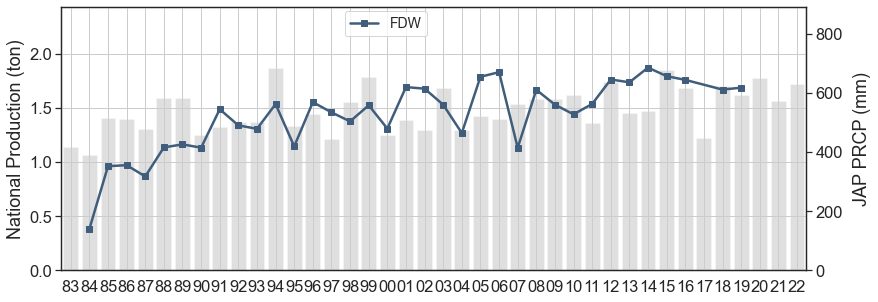

In [3]:
# Load precipitation --------------------------------- #
prcp = pd.read_hdf('./data/adm.prcp.chirps-v2.crop.extended.hdf')[fnids]
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == 7]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = 'JAP PRCP (mm)'
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'Correlation:\n{corr_value}')
# ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(1983,2023)
sns.set(style="white", font_scale=1.5)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'])
marker = ['s','*']
for i, line in enumerate(ax1.get_lines()): line.set_marker(marker[i])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_ylim([0, data.max().max()*1.3])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #

### Annual (Main-season) Production - Maize

Correlation:
           FDW       FAO      PRCP
FDW   1.000000  0.998577  0.516686
FAO   0.998577  1.000000  0.524706
PRCP  0.516686  0.524706  1.000000


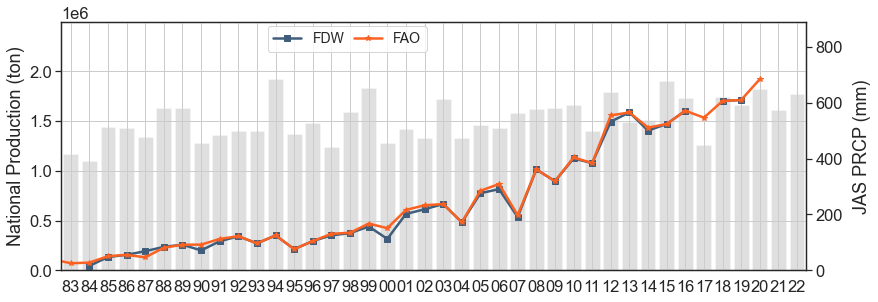

In [4]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
# Deyr-season
df = df[
    (df['season_name'] == 'Main') &
    (df['product'].isin(['Maize'])) &
    (df['indicator'] == 'production')
]
df['year'] = df['growing_year']
data_fdw = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# ---------------------------------------------------- #

# Load FAO-STAT National Production Data ------------- #
df = pd.read_csv('./data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == 'Burkina Faso') &
    (df['cpc2_name'] == 'Maize (corn)') &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# ---------------------------------------------------- #
data = pd.concat([data_fdw, data_fao], axis=1, keys=['FDW','FAO']).sort_index()

# Load precipitation --------------------------------- #
prcp = pd.read_hdf('./data/adm.prcp.chirps-v2.crop.extended.hdf')[fnids]
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == 7]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = 'JAS PRCP (mm)'
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'Correlation:\n{corr_value}')
# ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(1983,2023)
sns.set(style="white", font_scale=1.5)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'])
marker = ['s','*']
for i, line in enumerate(ax1.get_lines()): line.set_marker(marker[i])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_ylim([0, data.max().max()*1.3])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #

### Annual (Main-season) Production - Sorghum

Correlation:
           FDW       FAO      PRCP
FDW   1.000000  0.918511  0.544052
FAO   0.918511  1.000000  0.494460
PRCP  0.544052  0.494460  1.000000


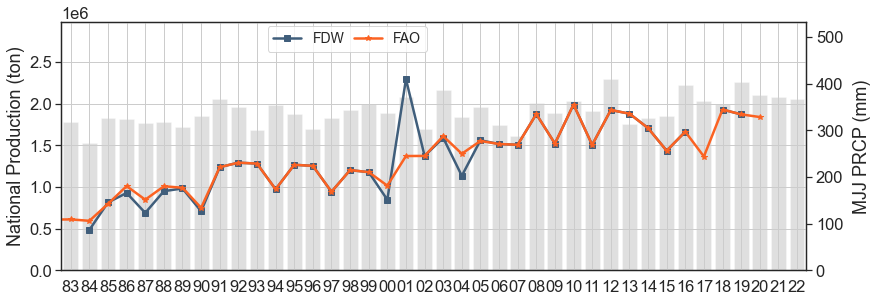

In [5]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
# Deyr-season
df = df[
    (df['season_name'] == 'Main') &
    (df['product'].isin(['Sorghum'])) &
    (df['indicator'] == 'production')
]
df['year'] = df['growing_year']
data_fdw = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# ---------------------------------------------------- #

# Load FAO-STAT National Production Data ------------- #
df = pd.read_csv('./data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == 'Burkina Faso') &
    (df['cpc2_name'] == 'Sorghum') &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# ---------------------------------------------------- #
data = pd.concat([data_fdw, data_fao], axis=1, keys=['FDW','FAO']).sort_index()

# Load precipitation --------------------------------- #
prcp = pd.read_hdf('./data/adm.prcp.chirps-v2.crop.extended.hdf')[fnids]
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == 5]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = 'MJJ PRCP (mm)'
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'Correlation:\n{corr_value}')
# ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(1983,2023)
sns.set(style="white", font_scale=1.5)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'], alpha=1)
marker = ['s','*']
for i, line in enumerate(ax1.get_lines()): line.set_marker(marker[i])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_ylim([0, data.max().max()*1.3])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #